# This notebook implements Wasserstein GAN.


In [15]:
# !pip install -r requirements.txt

In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import os
import numpy as np

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline



In [17]:
manualSeed = np.random.randint(1, 10000) # fix seed
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

if not os.path.isdir('visualization'):
   os.mkdir('visualization')
if not os.path.isdir('data'):
   os.mkdir('data')

Random Seed:  3483


In [18]:
n_layers = 5

In [19]:
class Config:
    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

conf = Config(im_shape = 4*2**n_layers,
            latent_size = 100,
            in_channels=3,
            out_channels = 16,
            n_layers = n_layers,
            batch_size = 8,
            num_iter = 5000,
            frezze_buffer=100,
            num_workers=2,
            device='cuda')

In [20]:
# Get dataset from image folder
dataset = Dataset.ImageFolder(root="data/celeba",
                        transform=transforms.Compose([
                            transforms.Resize(conf.im_shape),
                            transforms.CenterCrop(conf.im_shape),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ]))
# loader that handle loading stuff
loader = torch.utils.data.DataLoader(dataset, shuffle=True,#, pin_memory=True,
            batch_size=conf.batch_size, 
            drop_last=True,
            num_workers=conf.num_workers)

In [21]:
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True)
                                  + 1e-8)

In [22]:
def weights_init(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

In [23]:
class DecoderBlock(nn.Module):
    '''
    Reverse of Encoder
    '''
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
                                    # nn.BatchNorm2d(out_channels),
                                    PixelNorm(),
                                    nn.LeakyReLU(0.1),
                                    )

        
    def forward(self,x):
        return(self.block(x))
        
class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.input = nn.Sequential(nn.ConvTranspose2d(config.latent_size, config.out_channels*(2**(n_layers)), 4, stride=1, bias=False),
                                # nn.BatchNorm2d(config.out_channels*(2**(n_layers))),
                                PixelNorm(),
                                nn.LeakyReLU(0.1),
                                )
                    
        self.decode = nn.ModuleList([DecoderBlock(config.out_channels*2**(i+1), config.out_channels*2**i) 
                                    for i in range(config.n_layers-1,-1,-1)])
        
        self.out = nn.ModuleList([nn.Conv2d(config.out_channels*2**(i), config.in_channels, 1, 
                                stride=1, padding=0, bias=False) for i in range(config.n_layers,-1,-1)])


        self.out_channels = config.out_channels
        self.n_layers = config.n_layers

    def forward(self, x, step=None):
        if step is None:
            step = self.n_layers
            
        x = self.input(x)
        for i in range(step):
            x = self.decode[i](x)

        x = self.out[step](x)
        x = torch.tanh(x)
        
        return x


generator = Generator(conf).to(conf.device)
summary(generator,(100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
      DecoderBlock-7            [-1, 256, 8, 8]               0
   ConvTranspose2d-8          [-1, 128, 16, 16]         524,288
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        LeakyReLU-10          [-1, 128, 16, 16]               0
     DecoderBlock-11          [-1, 128, 16, 16]               0
  ConvTranspose2d-12           [-1, 64, 32, 32]         131,072
      BatchNorm2d-13           [-1, 64, 32, 32]             128
        LeakyReLU-14           [-1, 64,

In [24]:
class EncoderBlock(nn.Module):
    '''
    Typical CNN network that reduces spacial dimension and increase channels at each step.
    '''
    def __init__(self, in_channels, out_channels):
        super().__init__()

        
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(out_channels),
                                nn.LeakyReLU(0.1),
                                )
        
    def forward(self,x):
        return(self.block(x))

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.input = nn.Sequential(nn.Conv2d(config.in_channels, config.out_channels, 3, stride=1, padding=1, bias=False),
                                nn.BatchNorm2d(config.out_channels),
                                nn.LeakyReLU(0.1),
                                )
        self.encode = nn.ModuleList([EncoderBlock(config.out_channels*2**i, config.out_channels*2**(i+1)) 
                                    for i in range(config.n_layers)])
        
        self.out =  nn.ModuleList([nn.Conv2d(config.out_channels*2**i, config.latent_size, 4, stride=1, padding=0, bias=False)
                                    for i in range(config.n_layers+1)])       
        self.shared_linear = nn.Linear(config.latent_size,1)
        
        self.n_layers = config.n_layers

    def forward(self, x, step=None):
        if step is None:
            step = self.n_layers

        x = self.input(x)
        for i in range(step):
            x = self.encode[i](x)
        # output a single number for discriminator
        x = self.out[step](x).squeeze()
        x = self.shared_linear(x).mean()

        return x


discriminator = Discriminator(conf).to(conf.device)
summary(discriminator,[(3,4*2**conf.n_layers,4*2**conf.n_layers)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         LeakyReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4           [-1, 32, 64, 64]           4,608
       BatchNorm2d-5           [-1, 32, 64, 64]              64
         LeakyReLU-6           [-1, 32, 64, 64]               0
      EncoderBlock-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 32, 32]          18,432
       BatchNorm2d-9           [-1, 64, 32, 32]             128
        LeakyReLU-10           [-1, 64, 32, 32]               0
     EncoderBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 128, 16, 16]          73,728
      BatchNorm2d-13          [-1, 128, 16, 16]             256
        LeakyReLU-14          [-1, 128,

In [26]:
def show_progress(x, netD, it):
    '''
    Display and save visualization
    '''
    netD.eval()
    with torch.no_grad():
        num_vis = min(conf.batch_size, 8)
        x = x[0:num_vis]
        x = x.cpu().numpy()
        
        for i, obj_plot in enumerate(x):
            
            obj_plot = np.moveaxis(obj_plot, 0, -1)
            plt.imshow(obj_plot*0.5 +0.5)
            plt.axis('off')
            plt.show()
            plt.savefig('visualization/'+ str(it)+'.jpg', format='jpg', bbox_inches='tight')
    netD.train()

In [27]:
device = conf.device

netD = Discriminator(conf).to(device)
netG = Generator(conf).to(device)
netD.apply(weights_init)
netG.apply(weights_init)

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.001)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.001)

fixed_noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)

loss_D = []
loss_G = []
loss_D_smooth = 0
loss_G_smooth = 0



gan.D -41.09039 | gan.G -180.13176 | D_real -204.191 | D_fake -186.965:   0%|          | 0/5000 [00:02<?, ?it/s]

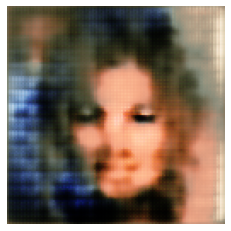

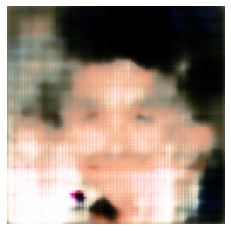

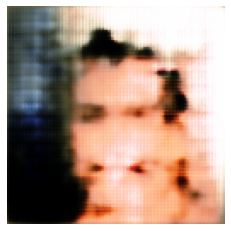

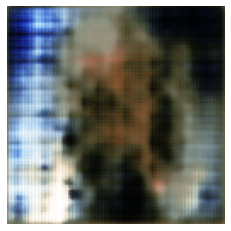

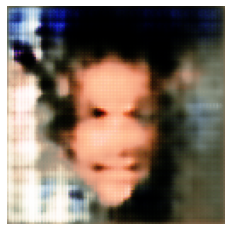

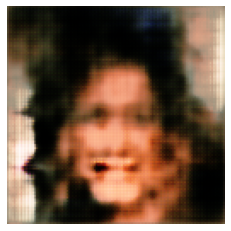

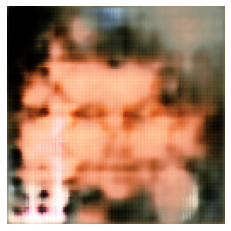

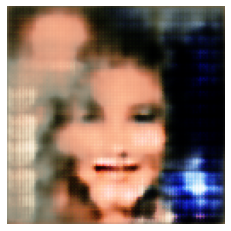

<Figure size 432x288 with 0 Axes>

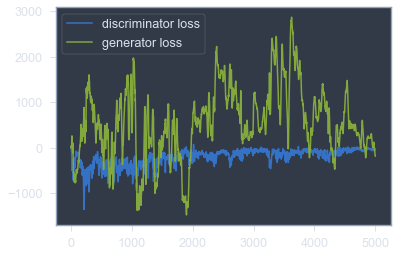

gan.D -31.01339 | gan.G 349.57298 | D_real 220.070 | D_fake 261.152:   4%|▍         | 200/5000 [00:50<18:59,  4.21it/s]

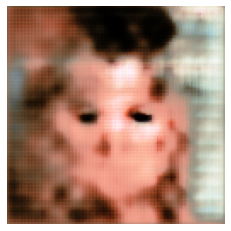

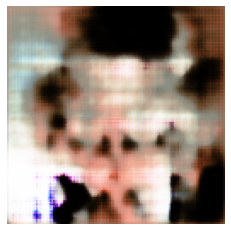

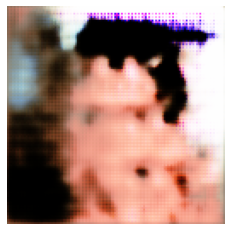

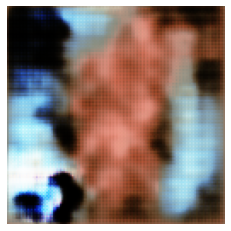

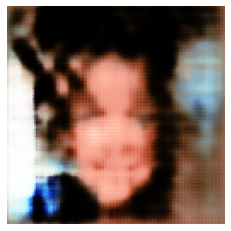

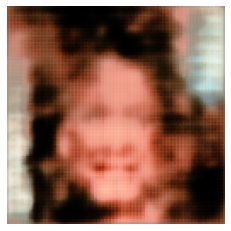

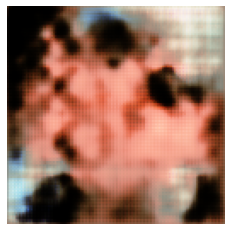

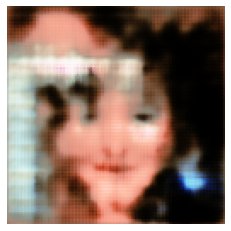

<Figure size 432x288 with 0 Axes>

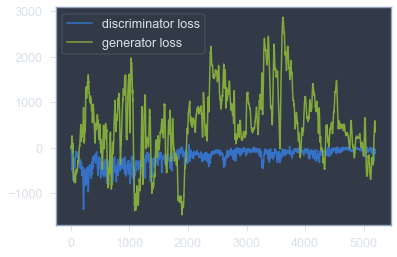

gan.D -27.05379 | gan.G -204.28136 | D_real -498.497 | D_fake -635.006:   8%|▊         | 400/5000 [01:39<17:58,  4.26it/s]

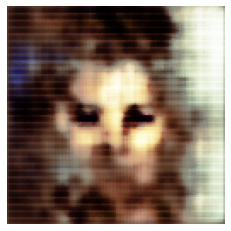

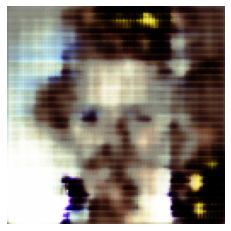

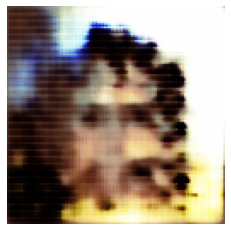

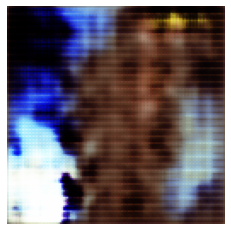

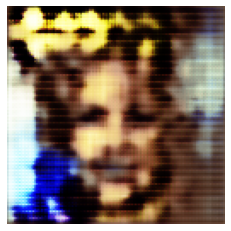

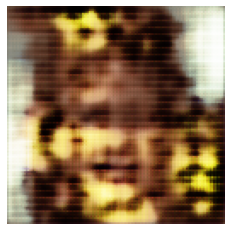

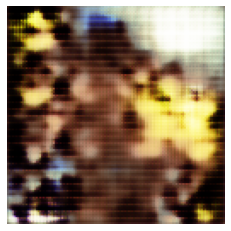

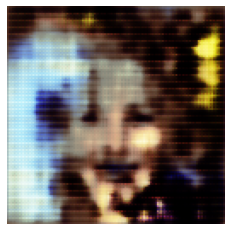

<Figure size 432x288 with 0 Axes>

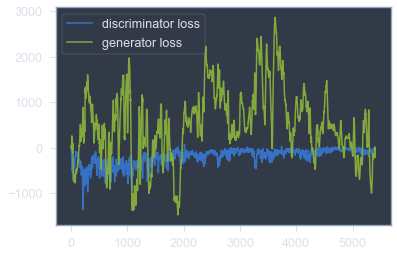

gan.D -65.02154 | gan.G -300.84400 | D_real -268.084 | D_fake -124.481:   9%|▉         | 467/5000 [01:56<18:35,  4.06it/s]

In [29]:
pbar = tqdm(range(conf.num_iter))
data_iter = iter(loader)
Diters = 1
for it in pbar:
    for step in range(conf.n_layers+1):
        for _ in range(Diters):
            try:
                x_real = data_iter.next()[0].to(device)
            except(OSError, StopIteration):
                data_iter = iter(loader)
                x_real = data_iter.next()[0].to(device)

            # train on multi resolution
            upscale = F.interpolate(x_real, scale_factor=2**(step - conf.n_layers), mode='bilinear', align_corners=False, recompute_scale_factor=False)
            
            
            netD.zero_grad()
            errD_real = netD(upscale, step)
            # noise that we will feed into gan.G
            
            with torch.no_grad():
                noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)
                x_fake = netG(noise, step)
            errD_fake = netD(x_fake, step)
            
            # Earth Mover loss to udpate gan.D
            errD = errD_real - errD_fake
            errD.backward()

            ### gradient penalty for D from the paper "Improved Training of Wasserstein GANs"
            eps = torch.rand(conf.batch_size, 1, 1, 1).to(device)
            x_hat = eps * upscale.data + (1 - eps) * x_fake.detach().data
            x_hat.requires_grad = True
            hat_predict = netD(x_hat, step=step)
            grad_x_hat = grad(
                outputs=hat_predict.sum(), inputs=x_hat, create_graph=True)[0]
            grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                                .norm(2, dim=1) - 1)**2).mean()
            grad_penalty = 10 * grad_penalty
            grad_penalty.backward()

            optimizerD.step()
        
        ############################
        # (2) Update G network
        ###########################

        netG.zero_grad()

        noise = torch.randn(conf.batch_size, 100, 1, 1).to(device)
        x_fake = netG(noise, step)
        errG = netD(x_fake, step)
        errG.backward()
        optimizerG.step()
        

    loss_D_smooth = 0.9*loss_D_smooth + 0.1*errD.item()
    loss_D.append(loss_D_smooth)
            
    loss_G_smooth = 0.9*loss_G_smooth + 0.1*errG.item()
    loss_G.append(loss_G_smooth)
    
    
    pbar.set_description(f"gan.D {loss_D_smooth:.5f} | gan.G {loss_G_smooth:.5f} | D_real {errD_real.item():.3f} | D_fake {errD_fake.item():.3f}")

    if it % 200 == 0:
        with torch.no_grad():
            x_fake = netG(fixed_noise, conf.n_layers)
        show_progress(x_fake, netD, it)
    
        plt.figure()
        plt.plot(range(len(loss_D)), loss_D)
        plt.plot(range(len(loss_G)), loss_G)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()
